# **جدیدتر و طبقه خواسته مسئله **

In [ ]:

import os
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import seaborn as sns
import kagglehub

import torch
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

warnings.filterwarnings('ignore')

dataset_path = kagglehub.dataset_download("dmitrybabko/speech-emotion-recognition-en")
print("Path to dataset files:", dataset_path)

def load_combined_dataset(path):
    audio_files = []
    labels = []

    valid_emotions = {'neutral', 'happy', 'sad', 'angry', 'fear', 'disgust', 'surprise', 'calm'}

    for root, dirs, files in os.walk(path):
        for filename in files:
            if filename.endswith('.wav'):
                full_path = os.path.join(root, filename)
                emotion = None

                fname = filename.lower()

                if "crema" in root.lower() or "cremad" in root.lower():
                    parts = filename.split('_')
                    if len(parts) > 2:
                        emotion_code = parts[2].lower()
                        crema_map = {
                            'hap': 'happy', 'sad': 'sad', 'ang': 'angry',
                            'neu': 'neutral', 'fea': 'fear', 'dis': 'disgust'
                        }
                        emotion = crema_map.get(emotion_code, None)

                elif "ravdess" in root.lower():
                    parts = filename.split('-')
                    if len(parts) > 2:
                        try:
                            emotion_id = int(parts[2])
                            ravdess_map = {
                                1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad',
                                5: 'angry', 6: 'fear', 7: 'disgust', 8: 'surprise'
                            }
                            emotion = ravdess_map.get(emotion_id, None)
                        except:
                            continue

                elif "tess" in root.lower():
                    base = filename.replace('.wav', '').lower()
                    parts = base.split('_')
                    if len(parts) > 1:
                        emotion = parts[-1]
                        if emotion == 'ps':
                            emotion = 'surprise'

                elif "savee" in root.lower():
                    prefix = filename[:2].upper()
                    savee_map = {
                        'DC': 'calm', 'JE': 'happy', 'JK': 'sad', 'KL': 'angry',
                        'MM': 'fear', 'SA': 'surprise', 'SU': 'disgust', 'NE': 'neutral'
                    }
                    emotion = savee_map.get(prefix, None)

                if emotion in valid_emotions:
                    audio_files.append(full_path)
                    labels.append(emotion)

    return audio_files, labels

all_files, all_labels = load_combined_dataset(dataset_path)

df = pd.DataFrame({
    'file_path': all_files,
    'label': all_labels
})



Path to dataset files: /kaggle/input/speech-emotion-recognition-en
تعداد کل فایل‌های بارگذاری‌شده: 12162

تعداد کل نمونه‌ها: 12162
label
happy       1983
angry       1983
sad         1983
disgust     1863
fear        1863
neutral     1583
surprise     592
calm         312
Name: count, dtype: int64
                                           file_path  label
0  /kaggle/input/speech-emotion-recognition-en/Sa...  happy
1  /kaggle/input/speech-emotion-recognition-en/Sa...  angry
2  /kaggle/input/speech-emotion-recognition-en/Sa...   calm
3  /kaggle/input/speech-emotion-recognition-en/Sa...   calm
4  /kaggle/input/speech-emotion-recognition-en/Sa...  angry



آمار مجموعه آموزش:
تعداد نمونه‌ها: 8513
توزیع کلاس‌ها:
label
angry       1388
happy       1388
sad         1388
fear        1304
disgust     1304
neutral     1108
surprise     414
calm         219
Name: count, dtype: int64


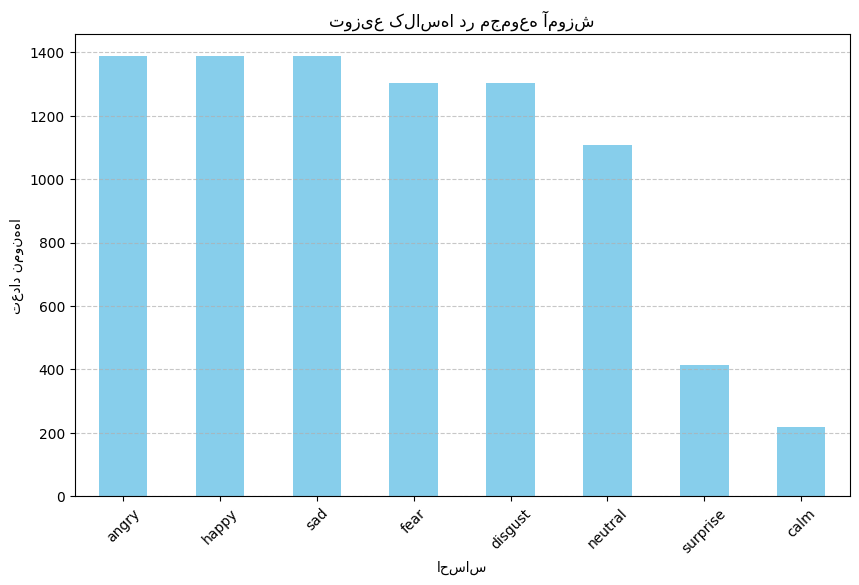


آمار مجموعه اعتبارسنجی:
تعداد نمونه‌ها: 2432
توزیع کلاس‌ها:
label
angry       396
sad         396
happy       396
fear        373
disgust     373
neutral     317
surprise    119
calm         62
Name: count, dtype: int64


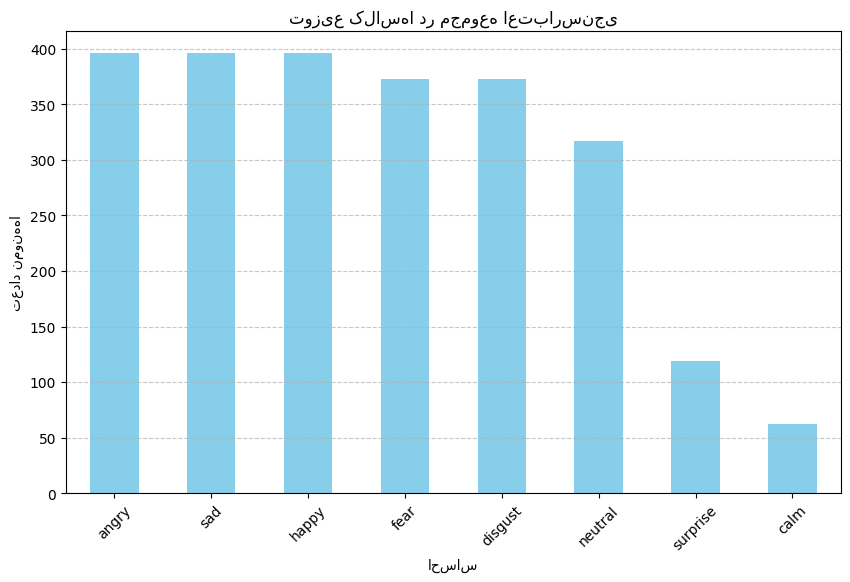


آمار مجموعه تست:
تعداد نمونه‌ها: 1217
توزیع کلاس‌ها:
label
angry       199
sad         199
happy       199
fear        186
disgust     186
neutral     158
surprise     59
calm         31
Name: count, dtype: int64


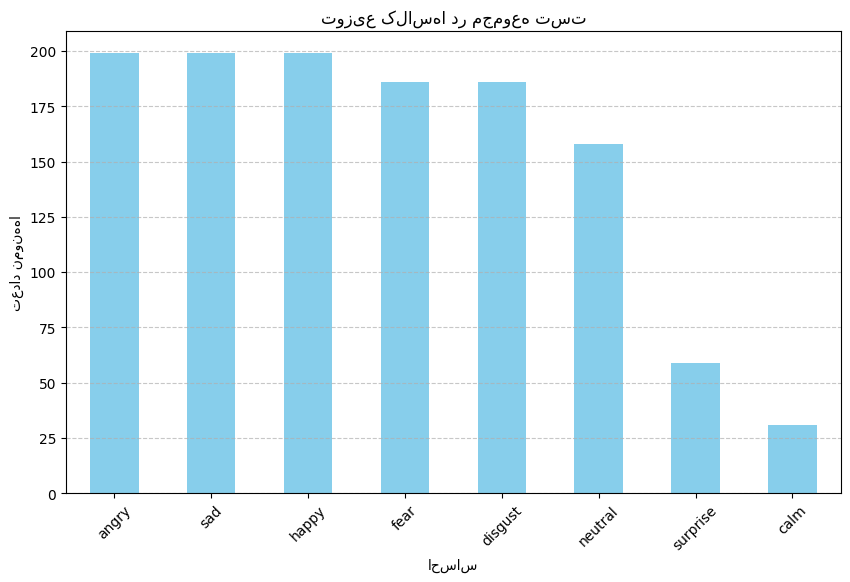

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.3333, stratify=temp_df['label'], random_state=42)

def print_split_stats_and_plot(df_split, name):
    print(f"\n{name} Set Statistics:")
    print(f"Number of samples: {len(df_split)}")
    class_counts = df_split['label'].value_counts()
    print("Class distribution:")
    print(class_counts)
    plt.figure(figsize=(10, 6))
    class_counts.plot(kind='bar', color='skyblue')
    plt.title(f'Class Distribution in {name} Set')
    plt.xlabel('Emotion')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

print_split_stats_and_plot(train_df, "Training")
print_split_stats_and_plot(valid_df, "Validation")
print_split_stats_and_plot(test_df, "Test")

train_df.to_csv('train_dataset.csv', index=False)
valid_df.to_csv('valid_dataset.csv', index=False)
test_df.to_csv('test_dataset.csv', index=False)


In [ ]:
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2ForSequenceClassification

label_list = sorted(df['label'].unique())
label2id = {label: idx for idx, label in enumerate(label_list)}
id2label = {idx: label for label, idx in label2id.items()}
print("Label Mapping:", label2id)

class SpeechEmotionDataset(Dataset):
    def __init__(self, df, processor, max_length=32000):
        self.df = df.reset_index(drop=True)
        self.processor = processor
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        audio_path = self.df.iloc[idx]['file_path']
        label_text = self.df.iloc[idx]['label']
        label = label2id[label_text]
        speech, sr = librosa.load(audio_path, sr=16000)
        if len(speech) > self.max_length:
            speech = speech[:self.max_length]
        else:
            speech = np.pad(speech, (0, self.max_length - len(speech)), mode='constant')
        inputs = self.processor(
            speech,
            sampling_rate=16000,
            return_tensors='pt',
            padding=True,
            truncation=True,
            max_length=self.max_length 
        )
        input_values = inputs.input_values.squeeze()
        return {'input_values': input_values, 'labels': torch.tensor(label, dtype=torch.long)}


feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained('facebook/wav2vec2-large-xlsr-53')
num_labels = len(label_list)

model_sentiment = Wav2Vec2ForSequenceClassification.from_pretrained(
    'facebook/wav2vec2-large-xlsr-53',
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
).to("cuda")

train_dataset = SpeechEmotionDataset(train_df, feature_extractor)
valid_dataset = SpeechEmotionDataset(valid_df, feature_extractor)
test_dataset  = SpeechEmotionDataset(test_df, feature_extractor)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=8, shuffle=False)
test_dataloader  = DataLoader(test_dataset, batch_size=8, shuffle=False)


مپینگ برچسب‌ها: {'angry': 0, 'calm': 1, 'disgust': 2, 'fear': 3, 'happy': 4, 'neutral': 5, 'sad': 6, 'surprise': 7}


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-large-xlsr-53 and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='./results_sentiment',
    evaluation_strategy='epoch',
    save_strategy='no',
    logging_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=20,
    weight_decay=0.01,
    report_to=[],
    fp16=True,
    logging_steps=10 
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

trainer = Trainer(
    model=model_sentiment,            
    args=training_args,
    train_dataset=train_dataset,      
    eval_dataset=valid_dataset,     
    compute_metrics=compute_metrics   
)

trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.389000,1.254574,0.542352,0.597555,0.542352,0.524762
2,1.149000,1.097513,0.620477,0.667356,0.620477,0.605325
3,1.034800,1.069618,0.628701,0.709000,0.628701,0.614739
4,0.921000,0.989279,0.650905,0.734757,0.650905,0.636247
5,0.826100,0.938925,0.685855,0.747353,0.685855,0.676717
6,0.782000,0.863977,0.712171,0.751325,0.712171,0.703949
7,0.730900,0.835035,0.725740,0.763506,0.725740,0.719952
8,0.694900,0.884064,0.727796,0.780228,0.727796,0.731451
9,0.630800,0.799291,0.745066,0.772431,0.745066,0.741151
10,0.608500,0.951141,0.708470,0.757705,0.708470,0.698801


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.389000,1.254574,0.542352,0.597555,0.542352,0.524762
2,1.149000,1.097513,0.620477,0.667356,0.620477,0.605325
3,1.034800,1.069618,0.628701,0.709000,0.628701,0.614739
4,0.921000,0.989279,0.650905,0.734757,0.650905,0.636247
5,0.826100,0.938925,0.685855,0.747353,0.685855,0.676717
6,0.782000,0.863977,0.712171,0.751325,0.712171,0.703949
7,0.730900,0.835035,0.725740,0.763506,0.725740,0.719952
8,0.694900,0.884064,0.727796,0.780228,0.727796,0.731451
9,0.630800,0.799291,0.745066,0.772431,0.745066,0.741151
10,0.608500,0.951141,0.708470,0.757705,0.708470,0.698801


TrainOutput(global_step=5340, training_loss=0.6914493089311579, metrics={'train_runtime': 4996.0123, 'train_samples_per_second': 34.079, 'train_steps_per_second': 1.069, 'total_flos': 1.032031156718592e+19, 'train_loss': 0.6914493089311579, 'epoch': 20.0})

In [ ]:
import shutil

output_dir = "./saved_model_sentiment"

model_sentiment.save_pretrained(output_dir)
feature_extractor.save_pretrained(output_dir) 
print(f"✅ Model saved at: {output_dir}")

zip_path = "saved_model_sentiment.zip"
shutil.make_archive("saved_model_sentiment", 'zip', output_dir)
print(f"✅ Model saved as ZIP: {zip_path}")


✅ Model saved at: ./saved_model_sentiment
✅ Model saved as ZIP: saved_model_sentiment.zip



نتایج ارزیابی مدل تشخیص احساسات:
accuracy: 0.7896
precision: 0.8038
recall: 0.7896
f1: 0.7855


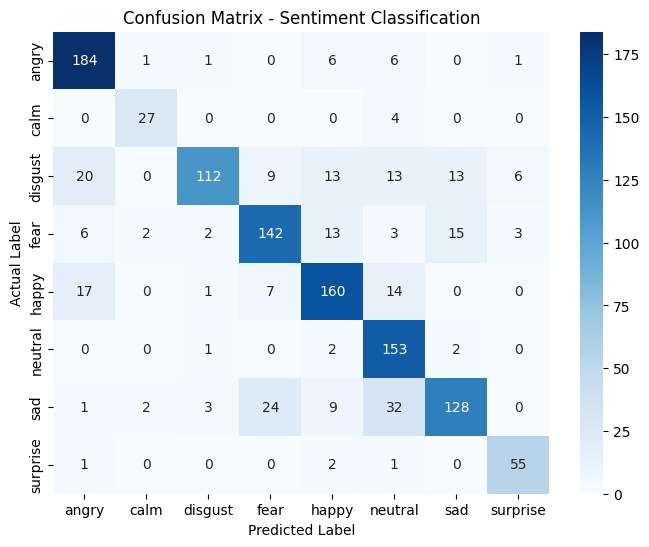

In [ ]:

eval_results = trainer.predict(test_dataset)
preds = eval_results.predictions.argmax(axis=-1)
true_labels = [item for item in test_dataset.dataset["labels"]] if hasattr(test_dataset, 'dataset') else [d["labels"].item() for d in test_dataset]
metrics = compute_metrics(eval_results)
print("\nEvaluation Results for the Emotion Detection Model:")
for key, value in metrics.items():
    print(f"{key}: {value:.4f}")

conf_matrix = confusion_matrix(test_dataset.dataset["labels"] if hasattr(test_dataset, 'dataset') else [d["labels"].item() for d in test_dataset], preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label2id.keys(), yticklabels=label2id.keys())
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix - Sentiment Classification")
plt.show()


In [ ]:
import random
import torch
import librosa
import numpy as np
from IPython.display import display, Audio
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2FeatureExtractor

output_dir = "./saved_model_sentiment"
model_sentiment = Wav2Vec2ForSequenceClassification.from_pretrained(output_dir).to("cuda")
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(output_dir)

MAX_LENGTH = 32000  

random_indices = random.sample(range(len(test_df)), 5)
random_samples = test_df.iloc[random_indices]

for idx, row in random_samples.iterrows():
    audio_path = row["file_path"]
    true_label = row["label"]

    speech, sr = librosa.load(audio_path, sr=16000)

    if len(speech) > MAX_LENGTH:
        speech = speech[:MAX_LENGTH]
    else:
        speech = np.pad(speech, (0, MAX_LENGTH - len(speech)), mode="constant")

    inputs = feature_extractor(speech, sampling_rate=16000, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LENGTH)
    input_values = inputs.input_values.to("cuda")

    with torch.no_grad():
        logits = model_sentiment(input_values).logits
    predicted_label_id = torch.argmax(logits, dim=-1).item()
    predicted_label = id2label[predicted_label_id]

    print(f"🔹 Sample {idx + 1}")
    print(f"   ✅ True Label: {true_label}")
    print(f"   🔮 Predicted Label: {predicted_label}")
    display(Audio(audio_path, rate=sr))
    print("-" * 40)


🔹 Sample 10215
   ✅ True Label: neutral
   🔮 Predicted Label: neutral


----------------------------------------
🔹 Sample 11343
   ✅ True Label: surprise
   🔮 Predicted Label: surprise


----------------------------------------
🔹 Sample 5888
   ✅ True Label: neutral
   🔮 Predicted Label: neutral


----------------------------------------
🔹 Sample 11485
   ✅ True Label: happy
   🔮 Predicted Label: happy


----------------------------------------
🔹 Sample 3961
   ✅ True Label: disgust
   🔮 Predicted Label: disgust


----------------------------------------


In [ ]:
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
from IPython.display import Audio, display

processor_ctc = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")
model_ctc = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-960h").to("cuda")

def transcribe_audio(file_path, max_length=40000):

    signal, sr = librosa.load(file_path, sr=16000)
    if len(signal) > max_length:
        signal = signal[:max_length]
    else:
        signal = np.pad(signal, (0, max_length - len(signal)), mode='constant')

    inputs = processor_ctc(signal, sampling_rate=16000, return_tensors="pt",
                             padding="longest", truncation=True, max_length=max_length)
    input_values = inputs.input_values.to("cuda")
    with torch.no_grad():
        logits = model_ctc(input_values).logits
    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = processor_ctc.batch_decode(predicted_ids)[0]
    return transcription

example_audio_path = test_df.iloc[0]["file_path"] 
transcript = transcribe_audio(example_audio_path)
print("\nمتن تشخیص داده شده (ASR):")
print(transcript)
display(Audio(example_audio_path, rate=16000))





preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



متن تشخیص داده شده (ASR):
SAY THE WORD FIT
